# Import and configure modules

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import tensorflow as tf

print("TF Version: ", tf.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

2022-05-31 01:36:15.697352: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-31 01:36:15.697388: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TF Version:  2.9.1
Eager mode enabled:  True
GPU available:  []


2022-05-31 01:36:19.096477: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-31 01:36:19.096511: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-31 01:36:19.096536: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (snp-0): /proc/driver/nvidia/version does not exist


In [15]:
# Set up some global values here

path_content = 'img/c40-recharge-scattered-gallery-1-4x3.jpg'
path_style = 'img/style_colorful_blocks.JPG'

# visualize inputs

In [6]:
def load_resize_img(path, max_dim=512):
    img = Image.open(path)
    
    long = max(img.size)
    scale = max_dim/long
    
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # We need to broadcast the image array such that it has a batch dimension 
    img_array = np.expand_dims(img, axis=0)
    return img_array

In [7]:
def display_img(img_array, title=None):
    # Remove the batch dimension
    out = np.squeeze(img_array, axis=0)
    # Normalize for display 
    out = out.astype('uint8')
    plt.imshow(out)
    if title:
        plt.title(title)
    return None

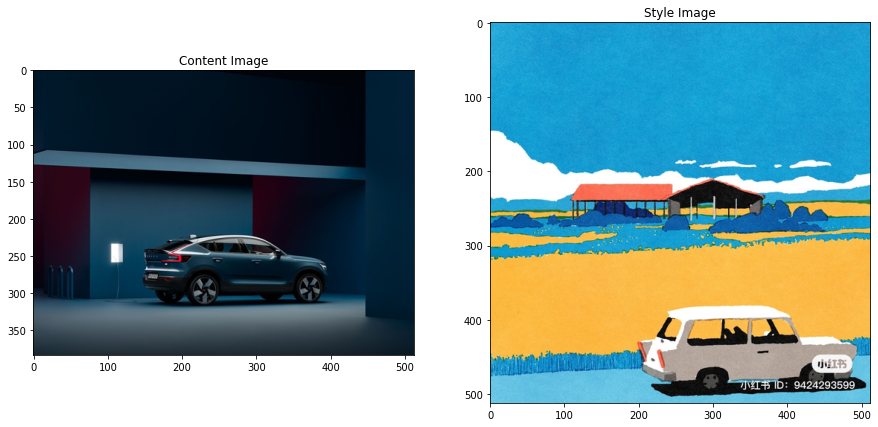

In [16]:
plt.figure(figsize=(15,15))

content = load_resize_img(path_content).astype('uint8')
style = load_resize_img(path_style).astype('uint8')

plt.subplot(1, 2, 1)
display_img(content, 'Content Image')

plt.subplot(1, 2, 2)
display_img(style, 'Style Image')
plt.show()

# algorithm

## model

In [17]:
def setup_model():
    # Content layer where will pull our feature maps
    layers_content = ['block5_conv2'] 

    # Style layer we are interested in
    layers_style = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1', 
                    'block4_conv1', 
                    'block5_conv1']

    num_layers_content = len(layers_content)
    num_layers_style = len(layers_style)

    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    # Get output layers corresponding to style and content layers 
    outputs_style = [vgg.get_layer(name).output for name in layers_style]
    outputs_content = [vgg.get_layer(name).output for name in layers_content]
    outputs_model = outputs_style + outputs_content

    model = tf.keras.Model(inputs=vgg.input, outputs=outputs_model, name='style transfer')
    for layer in model.layers:
        layer.trainable = False
    return model

In [13]:
model.summary()

Model: "style transfer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)

## input preprocess

In [14]:
def load_img_as_vgg_input(path):
    img_array = load_resize_img(path)
    img_vgg = tf.keras.applications.vgg19.preprocess_input(img_array)
    return img_vgg

def deprocess_img(img_processed):
    x = img_processed.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                               "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

## representations

In [65]:

def feature_representations(model, path_content, path_style):
    # Load our images in 
    input_vgg_content = load_img_as_vgg_input(path_content)
    input_vgg_style = load_img_as_vgg_input(path_style)

    # batch compute content and style features
    outputs_style = model(input_vgg_style)
    outputs_content = model(input_vgg_content)

    # Get the style and content feature representations from our model  
    features_style = [style_layer[0] for style_layer in outputs_style[:num_style_layers]]
    features_content = [content_layer[0] for content_layer in outputs_content[num_style_layers:]]
    return features_style, features_content

## loss function

In [ ]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

def compute_loss(model, loss_weights, input_vgg_init, features_style_gram, features_content):

    weight_style, weight_content = loss_weights

    # Feed our init image through our model. This will give us the content and 
    # style representations at our desired layers. Since we're using eager
    # our model is callable just like any other function!
    outputs_model = model(input_vgg_init)

    style_output_features = outputs_model[:num_style_layers]
    content_output_features = outputs_model[num_style_layers:]

    score_style = 0
    score_content = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(features_style_gram, style_output_features):
        score_style += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(features_content, content_output_features):
        score_content += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

    score_style *= weight_style
    score_content *= weight_content

    # Get total loss
    loss_total = score_style + score_content 
    return loss_total, score_style, score_content

## optimization

In [69]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        losses = compute_loss(**cfg)
        
    # Compute gradients wrt input image
    loss_total = losses[0]
    return tape.gradient(loss_total, cfg['input_vgg_init']), losses

In [73]:
iterations = 1000
weight_content=1e3
weight_style=1e-2

In [76]:
# Get the style and content feature representations (from our specified intermediate layers) 
features_style, features_content = feature_representations(model, path_content, path_style)
features_style_gram = [gram_matrix(feature_style) for feature_style in features_style]

# Set initial image
input_vgg_init = load_img_as_vgg_input(path_content)
input_vgg_init = tf.Variable(input_vgg_init, dtype=tf.float32)

# Create our optimizer
opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
# Create a nice config 
loss_weights = (weight_style, weight_content)

cfg = {
  'model': model,
  'loss_weights': loss_weights,
  'input_vgg_init': input_vgg_init,
  'features_style_gram': features_style_gram,
  'features_content': features_content
}


# For displaying intermediate images 
iter_count = 1
# For displaying
num_rows = 2
num_cols = 5
# display_interval = iterations/(num_rows*num_cols)
display_interval = 1
start_time = time.time()
global_start = time.time()

norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means 

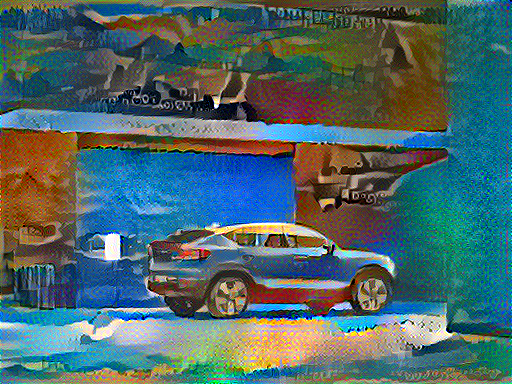

Iteration: 999
Total loss: 1.8068e+06, style loss: 1.1548e+06, content loss: 6.5199e+05, time: 0.0797s


In [77]:
# Store our best result
best_loss, best_img = float('inf'), None
imgs = []

for i in range(iterations):
    grads, losses = compute_grads(cfg)
    loss, score_style, score_content = losses
    opt.apply_gradients([(grads, input_vgg_init)])
    clipped = tf.clip_by_value(input_vgg_init, min_vals, max_vals)
    input_vgg_init.assign(clipped)
    end_time = time.time() 

    if loss < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = loss
        best_img = deprocess_img(input_vgg_init.numpy())

    if i % display_interval== 0:
        start_time = time.time()

        # Use the .numpy() method to get the concrete numpy array
        plot_img = input_vgg_init.numpy()
        plot_img = deprocess_img(plot_img)
        imgs.append(plot_img)
        IPython.display.clear_output(wait=True)
        IPython.display.display_png(Image.fromarray(plot_img))
        print('Iteration: {}'.format(i))        
        print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '
              'time: {:.4f}s'.format(loss, score_style, score_content, time.time() - start_time))

In [82]:
def show_results(best_img, path_content, path_style, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_resize_img(path_content) 
    style = load_resize_img(path_style)

    plt.subplot(1, 2, 1)
    display_img(content, 'Content Image')

    plt.subplot(1, 2, 2)
    display_img(style, 'Style Image')

    if show_large_final: 
        plt.figure(figsize=(10, 10))

        plt.imshow(best_img)
        plt.title('Output Image')
        plt.show()

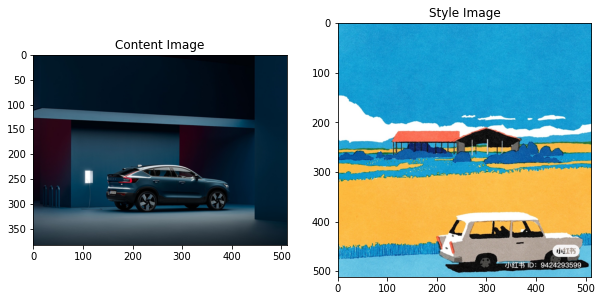

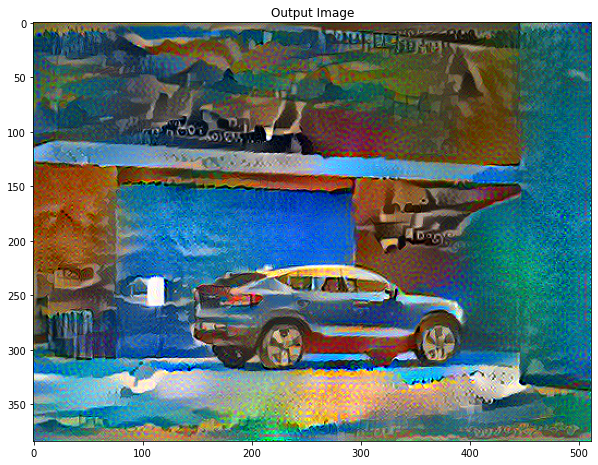

In [83]:
show_results(best_img, path_content, path_style)

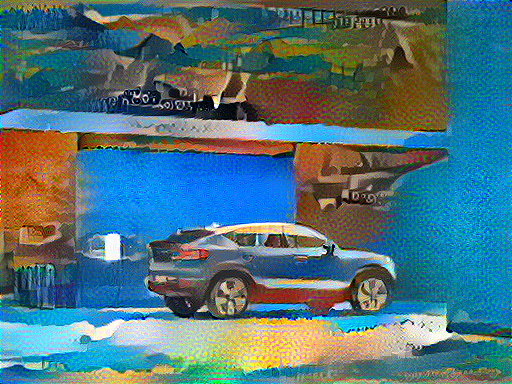

Iteration: 999
Total loss: 1.1634e+06, style loss: 6.4677e+05, content loss: 5.1665e+05, time: 0.0792s


In [84]:
for i in range(iterations):
    grads, losses = compute_grads(cfg)
    loss, score_style, score_content = losses
    opt.apply_gradients([(grads, input_vgg_init)])
    clipped = tf.clip_by_value(input_vgg_init, min_vals, max_vals)
    input_vgg_init.assign(clipped)
    end_time = time.time() 

    if loss < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = loss
        best_img = deprocess_img(input_vgg_init.numpy())

    if i % display_interval== 0:
        start_time = time.time()

        # Use the .numpy() method to get the concrete numpy array
        plot_img = input_vgg_init.numpy()
        plot_img = deprocess_img(plot_img)
        imgs.append(plot_img)
        IPython.display.clear_output(wait=True)
        IPython.display.display_png(Image.fromarray(plot_img))
        print('Iteration: {}'.format(i))        
        print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '
              'time: {:.4f}s'.format(loss, score_style, score_content, time.time() - start_time))

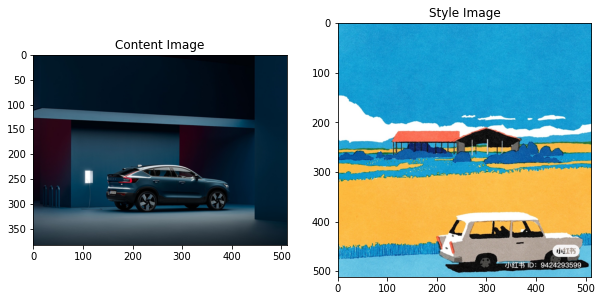

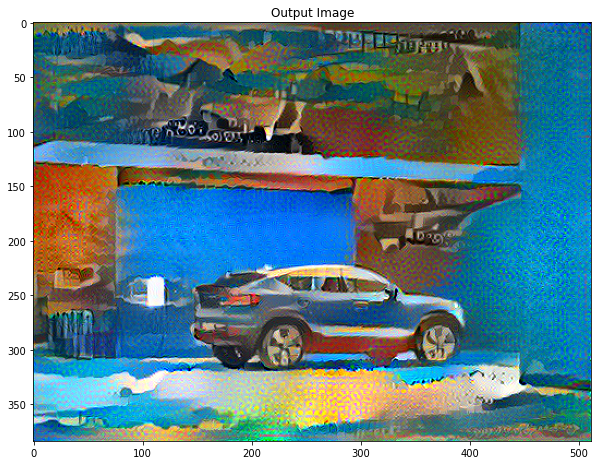

In [85]:
show_results(best_img, path_content, path_style)

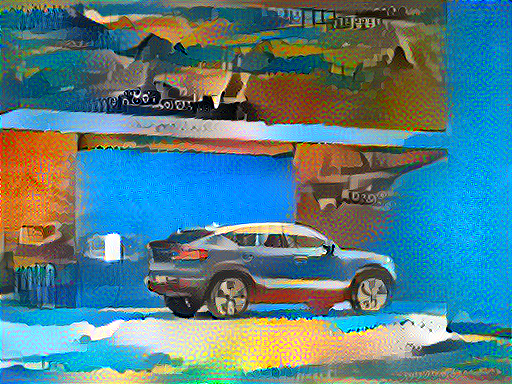

Iteration: 999
Total loss: 9.4446e+05, style loss: 4.8114e+05, content loss: 4.6333e+05, time: 0.0813s


In [86]:
for i in range(iterations):
    grads, losses = compute_grads(cfg)
    loss, score_style, score_content = losses
    opt.apply_gradients([(grads, input_vgg_init)])
    clipped = tf.clip_by_value(input_vgg_init, min_vals, max_vals)
    input_vgg_init.assign(clipped)
    end_time = time.time() 

    if loss < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = loss
        best_img = deprocess_img(input_vgg_init.numpy())

    if i % display_interval== 0:
        start_time = time.time()

        # Use the .numpy() method to get the concrete numpy array
        plot_img = input_vgg_init.numpy()
        plot_img = deprocess_img(plot_img)
        imgs.append(plot_img)
        IPython.display.clear_output(wait=True)
        IPython.display.display_png(Image.fromarray(plot_img))
        print('Iteration: {}'.format(i))        
        print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '
              'time: {:.4f}s'.format(loss, score_style, score_content, time.time() - start_time))

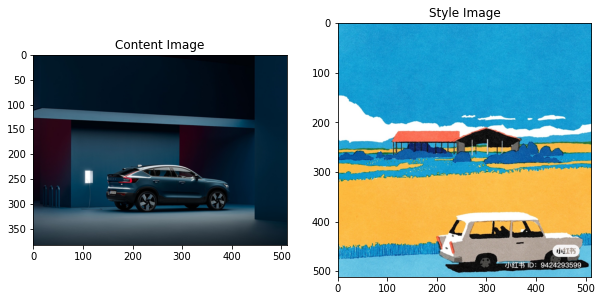

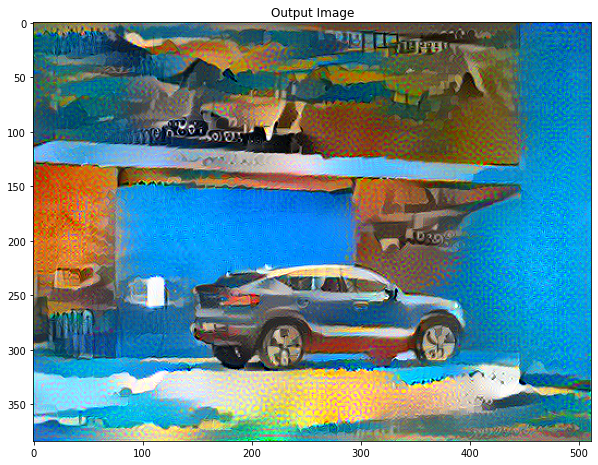

In [87]:
show_results(best_img, path_content, path_style)

In [92]:
def optimize(best_img, best_loss, input_vgg_init, iterations=1000, display=True, display_interval=1, cfg=None):
    
    # Create our optimizer
    opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    display_interval = 1
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means 
    
    imgs = []
    for i in range(iterations):
        grads, losses = compute_grads(cfg)
        loss, score_style, score_content = losses
        opt.apply_gradients([(grads, input_vgg_init)])
        clipped = tf.clip_by_value(input_vgg_init, min_vals, max_vals)
        input_vgg_init.assign(clipped)
        end_time = time.time() 

        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = deprocess_img(input_vgg_init.numpy())
        
        if display:
            if i % display_interval== 0:
                start_time = time.time()

                # Use the .numpy() method to get the concrete numpy array
                plot_img = input_vgg_init.numpy()
                plot_img = deprocess_img(plot_img)
                imgs.append(plot_img)
                IPython.display.clear_output(wait=True)
                IPython.display.display_png(Image.fromarray(plot_img))
                print('Iteration: {}'.format(i))        
                print('Total loss: {:.2e}, ' 
                      'style loss: {:.2e}, '
                      'content loss: {:.2e}, '
                      'time: {:.4f}s'.format(loss, score_style, score_content, time.time() - start_time))
    return best_img, best_loss, input_vgg_init

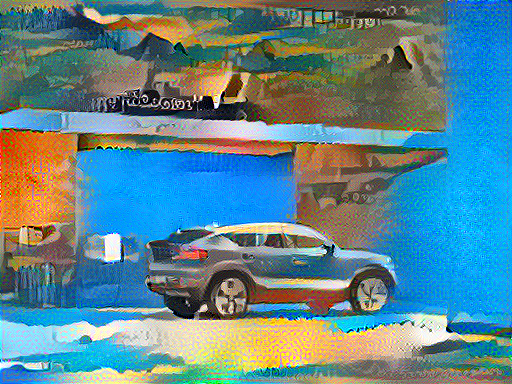

Iteration: 999
Total loss: 9.30e+05, style loss: 4.73e+05, content loss: 4.57e+05, time: 0.0828s


In [93]:
best_img_, best_loss_, input_vgg_init_ = optimize(best_img, best_loss, input_vgg_init, iterations=1000, display=True, cfg=cfg)

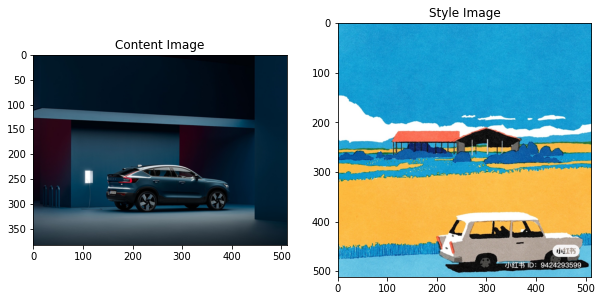

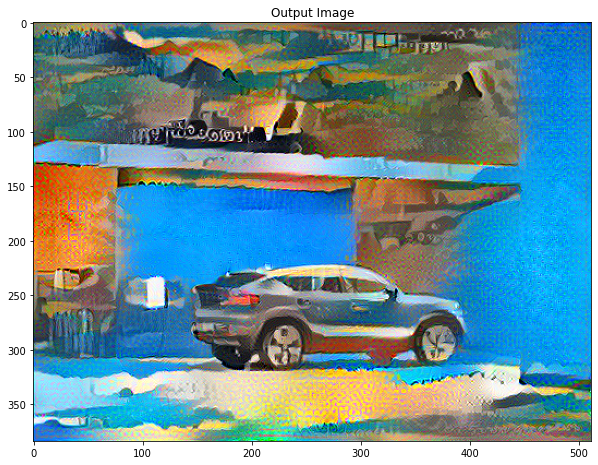

In [94]:
show_results(best_img_, path_content, path_style)

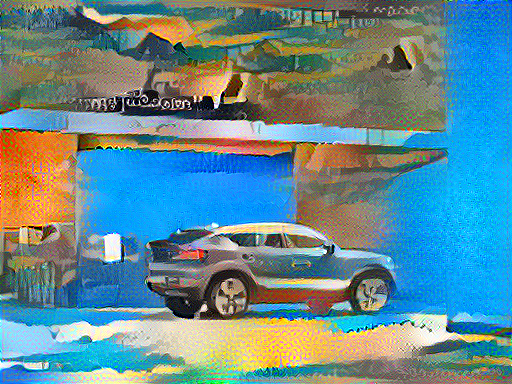

Iteration: 864
Total loss: 9.15e+05, style loss: 4.54e+05, content loss: 4.61e+05, time: 0.0999s


In [ ]:
best_img_, best_loss_, input_vgg_init_ = optimize(best_img_, best_loss_, input_vgg_init_, iterations=1000, display=True, cfg=cfg)

In [ ]:
show_results(best_img_, path_content, path_style)